In [1]:
'''
Dieses Program soll dazu dienen die
Radardaten von BoxPol mit den GPM Daten
hinsichtlich der Reflektivitat zu validieren.
Hier werden mehrere Ueberflug analysiert
created by V. Pejcic
'''


'\nDieses Program soll dazu dienen die\nRadardaten von BoxPol mit den GPM Daten\nhinsichtlich der Reflektivitat zu validieren.\nHier werden mehrere Ueberflug analysiert\ncreated by V. Pejcic\n'

# Einlesen von Modulen
------------------------

In [1]:
#!/usr/bin/env python

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import math
import pandas as pd
import wradlib
from scipy import stats
import matplotlib.cm as cm
my_cmap = cm.get_cmap('jet',40)
my_cmap.set_under('lightgrey')
my_cmap.set_over('darkred')
from pcc import get_miub_cmap as my_cmap
from pcc import plot_radar
from pcc import boxpol_pos
from pcc import plot_borders
import wradlib as wrl
from osgeo import osr
from satlib import ipoli_radi
from satlib import corcor
Pos = boxpol_pos()
blon0, blat0 = Pos['lon_ppi'], Pos['lat_ppi']
bbx, bby = Pos['gkx_ppi'], Pos['gky_ppi']
from time import *

% matplotlib inline

print ("_")

_


/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: DeprecationW

# Festlegen von Parametern und Dateipfaden
------------------

In [2]:
# Pfad mit String
# ---------------

# Hohe von DPR
TH = 15 #Threshold um Nullen fuer Niederschlag raus zu filtern

ipoli = [wradlib.ipol.Idw, wradlib.ipol.Linear, wradlib.ipol.Nearest, wradlib.ipol.OrdinaryKriging]
offset = 2

# Ereignisse 2014
#-#ZP = '20140806203538'; pfadnr=1; enigma='alt' 
#-#ZP = '20140826221000'; pfadnr=1; enigma='alt' # 0.82
#-#ZP = '20141007023744' ; pfadnr=0; enigma='alt'# 0.47
#-#ZP = '20141008094000'; pfadnr=1; enigma='alt' # 0.82   
#-#ZP = '20141008094500'; pfadnr=1; enigma='alt' # 0.679  
#-#ZP = '20141213141304'; pfadnr=0; enigma='alt' # 0.82
#-#ZP = '20141217054500' ; pfadnr=0; enigma='alt'# 0.47

# Ereignisse 2015
#-#ZP = '20150128171500'; pfadnr=0; enigma='alt' #0.28
#-#ZP = '20150128172208'; pfadnr=0; enigma='alt'#0.321
#-#ZP = '20150225163500'; pfadnr=0; enigma='alt'
#-#ZP = '20150330233003'; pfadnr=1; enigma='alt'
#-#ZP = '20150404053404'; pfadnr=0; enigma='alt'
#-#ZP = '20150626214445'; pfadnr=1; enigma='alt'
#-#ZP = '20151015203657'; pfadnr=1; enigma='alt'

#-#ZP = '20151211203853'; pfadnr=1; enigma='alt'
#-#ZP = '20151216024501'; pfadnr=0; enigma='alt'

# Ereignisse 2016
#-#ZP = '20160209103000'; pfadnr=1; enigma='alt'
#-#ZP = '20160601175950'; pfadnr=1; enigma='alt'
#-#ZP = '20161109185732'; pfadnr=1; enigma='alt'
#-#ZP = '20160107124707'; pfadnr=0; enigma='alt'

# Ereignisse 2017
#-#ZP = '20170211152500'; pfadnr=0 ; enigma='alt'
#-#ZP = '20170211153000'; pfadnr=0; enigma='alt'

#----------NEU--------------#

#ZP = '20170211153000'; pfadnr=0; enigma='alt'
#ZP = '20170321043000'; pfadnr=0; enigma='alt'
#ZP = '20170519110333'; pfadnr=0; enigma='neu'
#ZP = '20170725152833'; pfadnr=0; enigma='neu'
#ZP = '20170810110333'; pfadnr=0; enigma='neu'
#ZP = '20170909021332'; pfadnr=0; enigma='neu'
#ZP = '20171002025332'; pfadnr=0; enigma='neu'
#ZP = '20171126032331'; pfadnr=0; enigma='neu'
#ZP = '20171127103334'; pfadnr=0; enigma='neu'
ZP = '20180125170330'; pfadnr=0; enigma='neu'


#-----------------------------#

year = ZP[0:4]; ye = ZP[2:4]; m = ZP[4:6]; d = ZP[6:8]; ht = ZP[8:10]; mt = ZP[10:12]; st = ZP[12:14]


#pfad_radar = glob.glob('/automount/ags/velibor/gpmdata/dpr/2A.GPM.DPR.V6-20160118.' + year + m + d + '*.HDF5')
pfad_radar = glob.glob('/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.' + year + m + d + '*.HDF5')

print ('GPM:',pfad_radar)
pfad_radar = pfad_radar[pfadnr]
#pfad_radar_Ku = pfad_radar[0]

deg_scan =  ["/ppi_1p5deg/","/ppi_2p4deg/","/ppi_3p4deg/",
             "/n_ppi_010deg/","/n_ppi_045deg/",
             "/n_ppi_082deg/","/n_ppi_110deg/","/n_ppi_140deg/",
             "/n_ppi_180deg/","/n_ppi_280deg/","/n_vertical_scan/"][0]


if enigma=='neu':
    print ('New enigma')
    deg_scan =  ["/n_ppi_010deg/"][0]
    
    boxpolpath = '/automount/radar/scans/' + year+ "/" +year +"-"+ m + "/" + year+ "-" + m +"-"+ d +\
                               deg_scan+"*"+year+m+d+ht+mt+st+"*.h5"
    print (boxpolpath)    
    ppi_datapath=glob.glob(boxpolpath)
    
    print ('Boxpol: ',ppi_datapath)
    ppi_datapath = ppi_datapath[0]

    
else:
    try:
        ppi_datapath=glob.glob('/automount/radar-archiv/scans/' + year+ "/" +
                               year +"-"+ m + "/" + year+ "-" + m +"-"+ d +
                               deg_scan+ year + "-" + m +"-"+ d + "--" +ht +
                               ":"+mt+":"+st+",*.mvol")
        print ppi_datapath
        ppi_datapath = ppi_datapath[0]

    except:
        ppi_datapath=glob.glob('/automount/radar/scans/' + year+ "/" +
                               year +"-"+ m + "/" + year+ "-" + m +"-"+
                               d + deg_scan+ year + "-" + m +"-"+ d +
                               "--" +ht +":"+mt+":"+st+",*.mvol")
        print ('Old enigma')
        print ('Boxpol: ',ppi_datapath)
        ppi_datapath = ppi_datapath[0]


('GPM:', ['/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20180125-S161111-E174346.022216.V05A.HDF5'])
New enigma
/automount/radar/scans/2018/2018-01/2018-01-25/n_ppi_010deg/*20180125170330*.h5
('Boxpol: ', ['/automount/radar/scans/2018/2018-01/2018-01-25/n_ppi_010deg/n_ppi_010deg_12345_20180125170330_00.h5'])


# Einlesen von BoXPol Daten
------------------------
- Dämpfungskorrektur nach HB (wradlib)

- Clutter entfernen mit $\rho_{HV} > 0.85$

- Offset noch nicht eindeutig festgelegt

- kein Beamblockage 

- DPR Threshold


In [3]:
#################################################### PPI BoxPol Daten einlesen
#------------------------------------------------------------------------------

ppi=h5py.File(ppi_datapath,'r')
data, attrs = wradlib.io.read_GAMIC_hdf5(ppi_datapath)

ZH0 = data['SCAN0']['ZH']['data']
PHIDP = data['SCAN0']['PHIDP']['data']
r = attrs['SCAN0']['r']
az = attrs['SCAN0']['az']
elevation=attrs['SCAN0']['elevation']
lon_ppi = attrs['VOL']['Longitude']
lat_ppi = attrs['VOL']['Latitude']
alt_ppi = attrs['VOL']['Height']
rho = data['SCAN0']['RHOHV']['data']

R = ZH0
R[151:165]=np.nan


print ("________ATTCORR______")
pia_harrison = wrl.atten.correctAttenuationHB(
    R,
    coefficients = dict(a=4.57e-5, b=0.731, gate_length=1.0),
    mode="warn",
    thrs=59.)
pia_harrison[pia_harrison > 4.8] = 4.8

print ("________ATTCORR2______")
R = R + pia_harrison

print ("________CLUTTER______")
rho_th  = 0.85
R[rho<= rho_th] = np.nan

print ("________ofset______")
#R = R + 2
#?
print ("________beambl.______")

print ("________DPR Threshold______")
Z_boxpol = R
### Threshold for DPR sensitivity
Z_boxpol[Z_boxpol<TH]=np.nan


________ATTCORR______
________ATTCORR2______
________CLUTTER______
________ofset______
________beambl.______
________DPR Threshold______


In [6]:
r

array([   200.,    400.,    600.,    800.,   1000.,   1200.,   1400.,
         1600.,   1800.,   2000.,   2200.,   2400.,   2600.,   2800.,
         3000.,   3200.,   3400.,   3600.,   3800.,   4000.,   4200.,
         4400.,   4600.,   4800.,   5000.,   5200.,   5400.,   5600.,
         5800.,   6000.,   6200.,   6400.,   6600.,   6800.,   7000.,
         7200.,   7400.,   7600.,   7800.,   8000.,   8200.,   8400.,
         8600.,   8800.,   9000.,   9200.,   9400.,   9600.,   9800.,
        10000.,  10200.,  10400.,  10600.,  10800.,  11000.,  11200.,
        11400.,  11600.,  11800.,  12000.,  12200.,  12400.,  12600.,
        12800.,  13000.,  13200.,  13400.,  13600.,  13800.,  14000.,
        14200.,  14400.,  14600.,  14800.,  15000.,  15200.,  15400.,
        15600.,  15800.,  16000.,  16200.,  16400.,  16600.,  16800.,
        17000.,  17200.,  17400.,  17600.,  17800.,  18000.,  18200.,
        18400.,  18600.,  18800.,  19000.,  19200.,  19400.,  19600.,
        19800.,  200

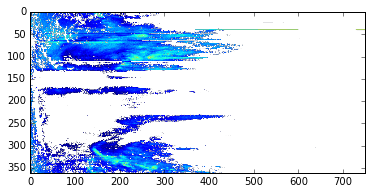

In [5]:
plt.imshow(Z_boxpol)
plt.show()

# Einlesen GPM DPR  Reflectivity (Corrected Near Surface)
------------------------------------

In [6]:
################################################################# DPR Einlesen
# -----------------------------------------------------------------------------
gpmku = h5py.File(pfad_radar, 'r')
gpmku_HS = gpmku['NS']['SLV']
dpr_lat = np.array(gpmku['NS']['Latitude'])
dpr_lon = np.array(gpmku['NS']['Longitude'])
Z_dpr = np.array(gpmku_HS['zFactorCorrectedNearSurface'])
Z_dpr[Z_dpr < TH] = np.nan

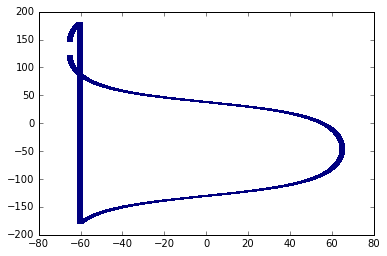

In [7]:
plt.pcolormesh(dpr_lat,dpr_lon,Z_dpr)
plt.show()

# RADOLAN RX Produkt einlesen
----------------------------------------

- DPR Threshold einstellen


In [8]:
############################################################## RADOLAN einlesen
# -----------------------------------------------------------------------------
#mt ='55'
#print mt

mtt = mt
mtt = str(int(round(float(mtt)/5.0)*5.0))

#mtt = '55'

if mtt == '0':
    mtt = '00'      
if mtt == '5':
    mtt = '05'
 
r_pro = 'rx'

pfad = ('/automount/radar/dwd/'+ r_pro +'/'+str(year)+'/'+str(year)+'-'+
        str(m)+'/'+ str(year)+'-'+str(m)+'-'+str(d)+'/raa01-'+r_pro+'_10000-'+
        str(ye)+str(m)+ str(d)+str(ht)+str(mtt)+'-dwd---bin.gz')

pfad_radolan = pfad[:-3]

try:
    rw_filename = wradlib.util.get_wradlib_data_file(pfad)
except EnvironmentError:
    rw_filename = wradlib.util.get_wradlib_data_file(pfad_radolan)

rwdata, rwattrs = wradlib.io.read_RADOLAN_composite(rw_filename)

radolan_zeit = rwattrs['datetime'].strftime("%Y.%m.%d -- %H:%M:%S")
#Binaere Grid
rn = rwdata.copy()
rn[rn != -9999] = 1
rn[rn == -9999] = 0

radolan_grid_xy = wradlib.georef.get_radolan_grid(900,900)
x = radolan_grid_xy[:,:,0]
y = radolan_grid_xy[:,:,1]
rwdata = np.ma.masked_equal(rwdata, -9999) / 2 - 32.5

### Threshold for DPR sensitivity
rwdata[rwdata<TH]=np.nan
Z_radolan = rwdata


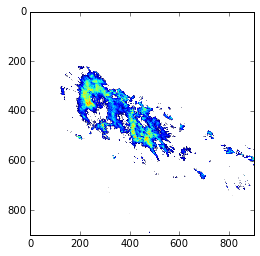

In [9]:
plt.imshow(Z_radolan)
plt.show()

# Unwichtige DPR Bereiche entfernen und Koordinatentransformation
--------------------

In [10]:
######################################################## Cut the Swath for Bonn
# -----------------------------------------------------------------------------

from pcc import cut_the_swath
dpr_lon, dpr_lat, Z_dpr = cut_the_swath(dpr_lon,dpr_lat,Z_dpr, eu=0)

In [11]:
######################################################## Koordinaten Projektion
# -----------------------------------------------------------------------------

proj_stereo = wrl.georef.create_osr("dwd-radolan")
proj_wgs = osr.SpatialReference()
proj_wgs.ImportFromEPSG(4326)

dpr_lon, dpr_lat = wradlib.georef.reproject(dpr_lon, dpr_lat,
                                            projection_target=proj_stereo ,
                                            projection_source=proj_wgs)

blon, blat = wradlib.georef.reproject(blon0, blat0,
                                      projection_target=proj_stereo ,
                                      projection_source=proj_wgs)


# DPR und Radolan auf BoXPol Bereich reduzieren
-------------------

In [12]:
############################################################### Dpr zuschneiden
#------------------------------------------------------------------------------

lon0, lat0, radius = blon, blat, r[-1]/1000.
rr = np.sqrt((dpr_lat - lat0)**2 + (dpr_lon - lon0)**2)
position = rr < radius

Z_dpr[np.where(rr > radius)] = np.nan

In [13]:
########################################################### RADOLAN zuschneiden
#------------------------------------------------------------------------------

rr2 = np.sqrt((y - lat0)**2 + (x - lon0)**2)
position2 = rr2 < radius

Z_radolan[np.where(rr2 > radius)] = np.nan

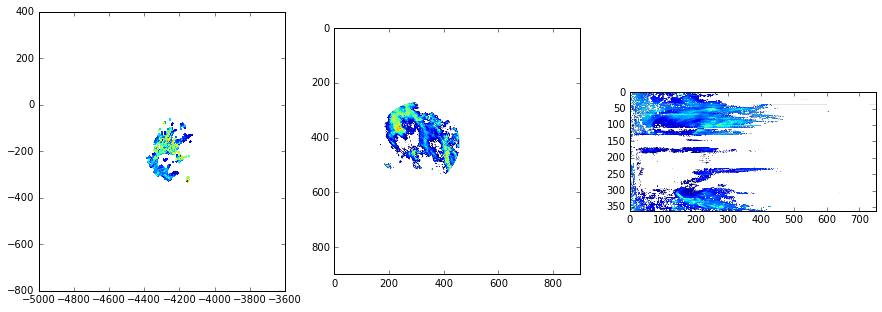

('DPR: ', array([15.277304, 15.392715, 15.516937, ...,       nan,       nan,
             nan], dtype=float32))
('RADOLAN: ', masked_array(data=[15.5, 16.5, 17.5, ..., nan, nan, nan],
             mask=[False, False, False, ..., False, False, False],
       fill_value=-9999))
('BoXPol: ', array([15.00012805, 15.00012966, 15.00060891, ...,         nan,
               nan,         nan]))


In [14]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.pcolormesh(dpr_lat,dpr_lon,np.ma.masked_invalid(Z_dpr))
plt.subplot(1,3,2); plt.imshow(Z_radolan)
plt.subplot(1,3,3); plt.imshow(Z_boxpol)
plt.show()

print ('DPR: ', np.unique(Z_dpr))
print ('RADOLAN: ',np.unique(Z_radolan))
print ('BoXPol: ', np.unique(Z_boxpol))

# Interpolieren von BoXPol und Radolan Daten auf das DPR Grid

----------------------------

- Interpolation mit einem Einfachen Mean aller im DPR Grid liegenden Pixel

In [15]:
################################################## BoXPol interpolieren auf DPR
#------------------------------------------------------------------------------
t1 = clock()
radar_location = (lon_ppi, lat_ppi, alt_ppi)
#elevation = 1.5
azimuths = az
ranges = r
polargrid = np.meshgrid(ranges, azimuths)
lon, lat, alt = wradlib.georef.polar2lonlatalt_n(polargrid[0], polargrid[1],
                                                 elevation, radar_location)
lon, lat = wradlib.georef.reproject(lon, lat, projection_target=proj_stereo ,
                                    projection_source=proj_wgs)

grid_xy = np.vstack((dpr_lon.ravel(), dpr_lat.ravel())).transpose()

xy=np.concatenate([lon.ravel()[:,None],lat.ravel()[:,None]], axis=1)



Z_boxpol_ipoli = ipoli_radi(xy,Z_boxpol.ravel(),grid_xy,2.5)
Z_boxpol_ipoli = Z_boxpol_ipoli.reshape(dpr_lon.shape)

t2 = clock()

/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecatedWarning: polar2lonlatalt_n is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_proj` instead.
satlib.py:849: RuntimeWarning: Mean of empty slice
  gr_ipoli_data[i] = np.nanmean(gr_data[rr < radius])


In [8]:
elevation

0.999755859375

In [16]:
################################################# RADOLAN interpolieren auf DPR
#------------------------------------------------------------------------------

xy_rado = np.vstack((x.ravel(), y.ravel())).transpose()

Z_radolan_ipoli = ipoli_radi(xy_rado,Z_radolan.ravel().filled(np.nan),grid_xy,2.5)
Z_radolan_ipoli = Z_radolan_ipoli.reshape(dpr_lon.shape)

t3 = clock()

In [17]:
print ('4Boxpol:', t2 - t1)
print ('4Radolan:', t3 - t2)

('4Boxpol:', 60.250778)
('4Radolan:', 145.51198799999997)


# Plot
-----------

pcc.py:372: DeprecatedWarning: open_shape is deprecated as of 0.11.1 and will be removed in 1.0.0. Use :func:`open_vector` instead.
  dataset, inLayer = wradlib.io.open_shape(filename)
pcc.py:475: DeprecatedWarning: polar2polyvert is deprecated as of 0.11.3 and will be removed in 1.0.0. Use :func:`spherical_to_polyvert` instead.
  (x_loc, y_loc))
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/wradlib/georef/polar.py:673: DeprecatedWarning: polar2lonlat is deprecated as of 0.11.3 and will be removed in 1.0.0.
  lon, lat = polar2lonlat(r, az, sitecoords)
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/wradlib/georef/polar.py:140: DeprecatedWarning: hor2aeq is deprecated as of 0.11.3 and will be removed in 1.0.0.
  delta, tau = hor2aeq(a, h, phi)
pcc.py:372: DeprecatedWarning: open_shape is deprecated as of 0.11.1 and will be removed in 1.0.0. Use :func:`open_vector` instead.
  dataset, inLayer = wradlib.io.open_shape(filename)
pcc.py:475: DeprecatedWarn

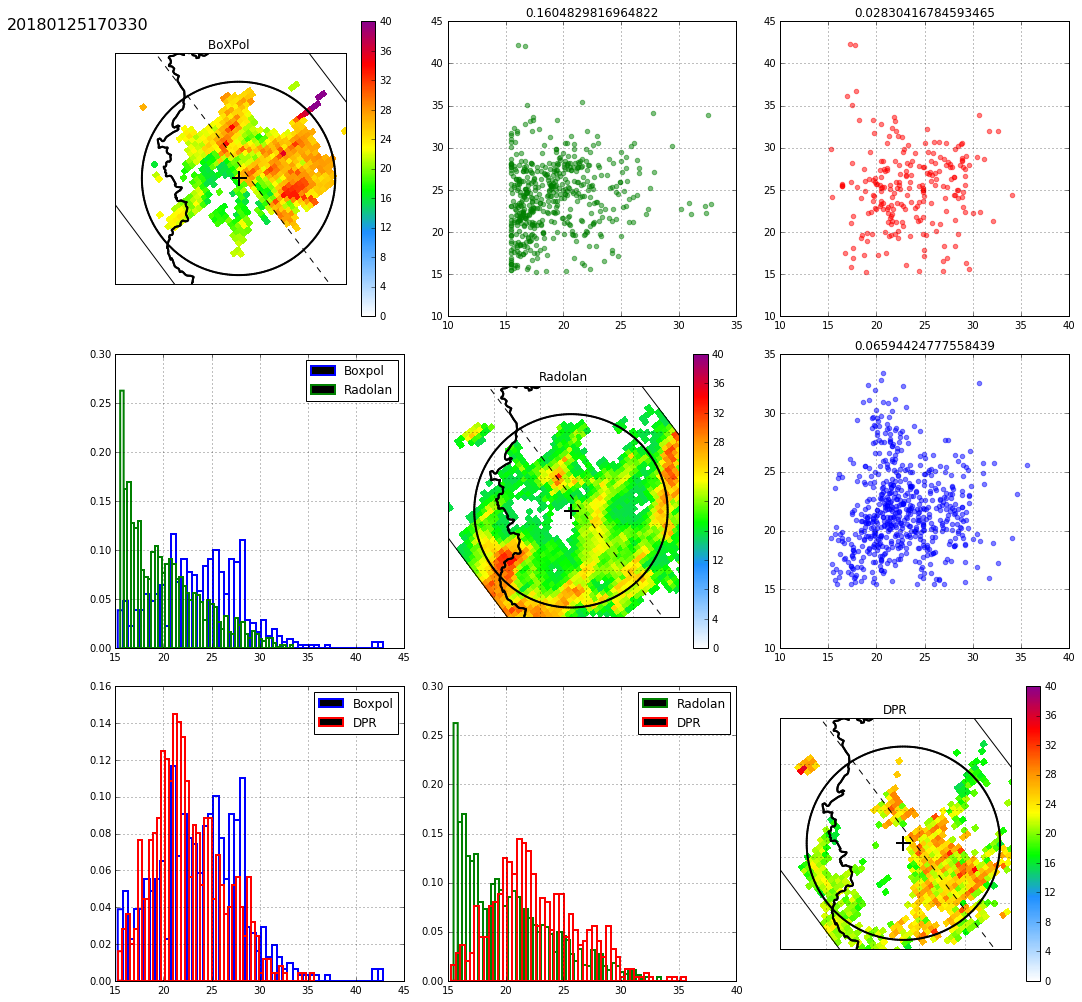

In [18]:
ff = 15
cc = 0.5
fig = plt.figure(figsize=(14,14))
fig.suptitle(ZP, fontsize=16, x=0)
ax1 = fig.add_subplot(331, aspect='equal')
plt.pcolormesh(dpr_lon, dpr_lat,np.ma.masked_invalid(Z_boxpol_ipoli),vmin=0, vmax=40, cmap=my_cmap())
plot_borders(ax1)
plot_radar(blon0, blat0, ax1, reproject=True, cband=False,col='black')
plt.plot(dpr_lon[:,0],dpr_lat[:,0], color='black',lw=1)
plt.plot(dpr_lon[:,-1],dpr_lat[:,-1], color='black',lw=1)
plt.plot(dpr_lon[:,dpr_lon.shape[1]/2],dpr_lat[:,dpr_lon.shape[1]/2], color='black',lw=1, ls='--')

plt.xlim(-350,-100)
plt.ylim(-4350, -4100)
plt.tick_params(
    axis='both',
    which='both',
    bottom='off',
    top='off',
    labelbottom='off',
    right='off',
    left='off',
    labelleft='off')
plt.grid()
plt.title('BoXPol ')
plt.colorbar()
plt.grid()



ax2 = fig.add_subplot(335, aspect='equal')
plt.pcolormesh(dpr_lon, dpr_lat,np.ma.masked_invalid(Z_radolan_ipoli),vmin=0, vmax=40, cmap=my_cmap())
plot_borders(ax2)
plot_radar(blon0, blat0, ax2, reproject=True, cband=False,col='black')
plt.plot(dpr_lon[:,0],dpr_lat[:,0], color='black',lw=1)
plt.plot(dpr_lon[:,-1],dpr_lat[:,-1], color='black',lw=1)
plt.plot(dpr_lon[:,dpr_lon.shape[1]/2],dpr_lat[:,dpr_lon.shape[1]/2], color='black',lw=1, ls='--')

plt.xlim(-350,-100)
plt.ylim(-4350, -4100)
plt.title('GPM - DPR')
plt.tick_params(
    axis='both',
    which='both',
    bottom='off',
    top='off',
    labelbottom='off',
    right='off',
    left='off',
    labelleft='off')
plt.grid()
plt.colorbar()
plt.title('Radolan')


ax3 = fig.add_subplot(339, aspect='equal')
plt.pcolormesh(dpr_lon, dpr_lat,np.ma.masked_invalid(Z_dpr),vmin=0, vmax=40, cmap=my_cmap())
plot_borders(ax3)
plot_radar(blon0, blat0, ax3, reproject=True, cband=False,col='black')
plt.plot(dpr_lon[:,0],dpr_lat[:,0], color='black',lw=1)
plt.plot(dpr_lon[:,-1],dpr_lat[:,-1], color='black',lw=1)
plt.plot(dpr_lon[:,dpr_lon.shape[1]/2],dpr_lat[:,dpr_lon.shape[1]/2], color='black',lw=1, ls='--')

plt.xlim(-350,-100)
plt.ylim(-4350, -4100)
plt.title('GPM - DPR')
plt.tick_params(
    axis='both',
    which='both',
    bottom='off',
    top='off',
    labelbottom='off',
    right='off',
    left='off',
    labelleft='off')
plt.grid()
plt.colorbar()
plt.title('DPR')

plt.subplot(3,3,3)
plt.scatter(Z_dpr,Z_boxpol_ipoli, color='red', alpha=0.5, label='Dpr vs Boxpol')
plt.title(corcor(Z_dpr,Z_boxpol_ipoli))
plt.grid()
plt.subplot(3,3,6)
plt.scatter(Z_dpr,Z_radolan_ipoli, color='blue', alpha=0.5, label='Dpr vs Radolan')
plt.title(corcor(Z_dpr,Z_radolan_ipoli))

plt.grid()
plt.subplot(3,3,2)
plt.scatter(Z_radolan_ipoli,Z_boxpol_ipoli, color='green', alpha=0.5, label='Radolan vs Boxpol')
plt.title(corcor(Z_radolan_ipoli,Z_boxpol_ipoli))

plt.grid()


m1, m2, m3 = ~np.isnan(Z_dpr), ~np.isnan(Z_boxpol_ipoli),~np.isnan(Z_radolan_ipoli)
bb, aa, ll = 50, 1, 2

plt.subplot(3,3,4)
plt.hist(Z_boxpol_ipoli[m2], bins=bb, alpha=aa, label='Boxpol',facecolor="None",
         edgecolor='blue', linewidth=ll, normed=1)
plt.hist(Z_radolan_ipoli[m3], bins=bb, alpha=aa, label='Radolan',facecolor="None",
         edgecolor='green', linewidth=ll, normed=1)
plt.grid()

plt.legend()
plt.subplot(3,3,7)
plt.hist(Z_boxpol_ipoli[m2], bins=bb, alpha=aa, label='Boxpol',facecolor="None",
         edgecolor='blue', linewidth=ll, normed=1)
plt.hist(Z_dpr[m1], bins=bb, alpha=aa, label='DPR',facecolor="None",
         edgecolor='red', linewidth=ll, normed=1)
plt.grid()
plt.legend()

plt.subplot(3,3,8)
plt.hist(Z_radolan_ipoli[m3], bins=bb, alpha=aa, label='Radolan',facecolor="None",
         edgecolor='green', linewidth=ll, normed=1)
plt.hist(Z_dpr[m1], bins=bb, alpha=aa, label='DPR',facecolor="None",
         edgecolor='red', linewidth=ll, normed=1)
plt.grid()
plt.legend()

plt.savefig('/automount/ags/velibor/plot/GPM_boxpol/topevents/cxk_'+ZP+'.png')
plt.tight_layout()
plt.show()

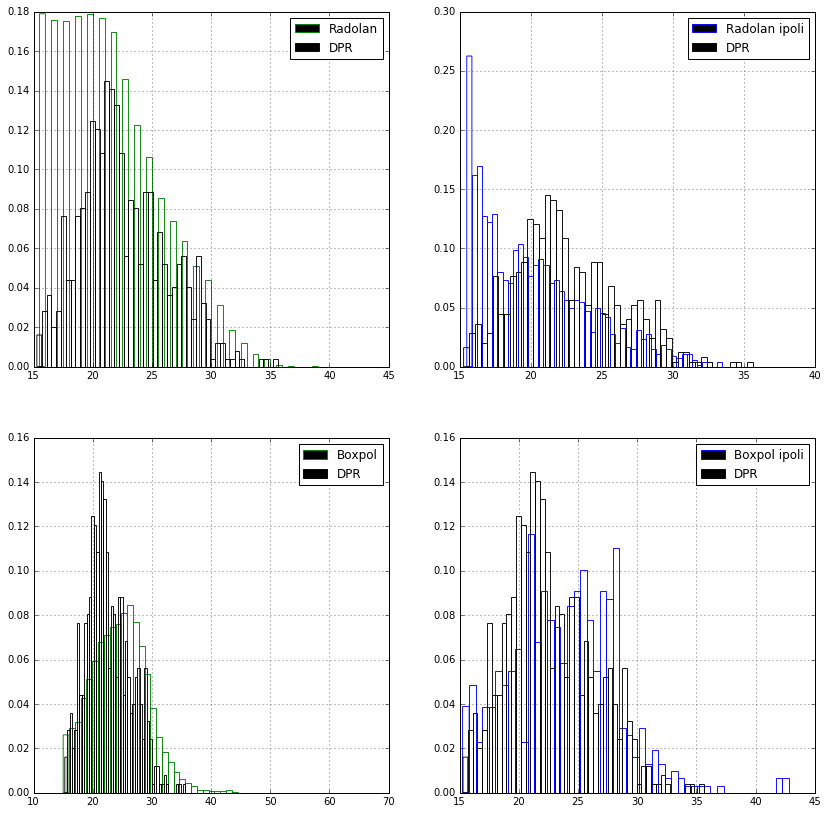

In [19]:
m4, m5 =  ~np.isnan(Z_boxpol),~np.isnan(Z_radolan)
ll = 0.9
fig = plt.figure(figsize=(14,14))

plt.subplot(2,2,1)
plt.hist(Z_radolan[m5], bins=bb, alpha=aa, label='Radolan',facecolor="None",
         edgecolor='green', linewidth=ll, normed=1)
plt.hist(Z_dpr[m1], bins=bb, alpha=aa, label='DPR',facecolor="None",
         edgecolor='black', linewidth=ll, normed=1)
plt.grid()
plt.legend()
plt.subplot(2,2,3)
plt.hist(Z_boxpol[m4], bins=bb, alpha=aa, label='Boxpol',facecolor="None",
         edgecolor='green', linewidth=ll, normed=1)
plt.hist(Z_dpr[m1], bins=bb, alpha=aa, label='DPR',facecolor="None",
         edgecolor='black', linewidth=ll, normed=1)
plt.grid()
plt.legend()

plt.subplot(2,2,2)
plt.hist(Z_radolan_ipoli[m3], bins=bb, alpha=aa, label='Radolan ipoli',facecolor="None",
         edgecolor='blue', linewidth=ll, normed=1)
plt.hist(Z_dpr[m1], bins=bb, alpha=aa, label='DPR',facecolor="None",
         edgecolor='black', linewidth=ll, normed=1)
plt.grid()
plt.legend()
plt.subplot(2,2,4)
plt.hist(Z_boxpol_ipoli[m2], bins=bb, alpha=aa, label='Boxpol ipoli',facecolor="None",
        edgecolor='blue', linewidth=ll, normed=1)
plt.hist(Z_dpr[m1], bins=bb, alpha=aa, label='DPR',facecolor="None",
         edgecolor='black', linewidth=ll, normed=1)
plt.grid()
plt.legend()
plt.savefig('/automount/ags/velibor/plot/GPM_boxpol/topevents/cxka_'+ZP+'.png')

plt.show()

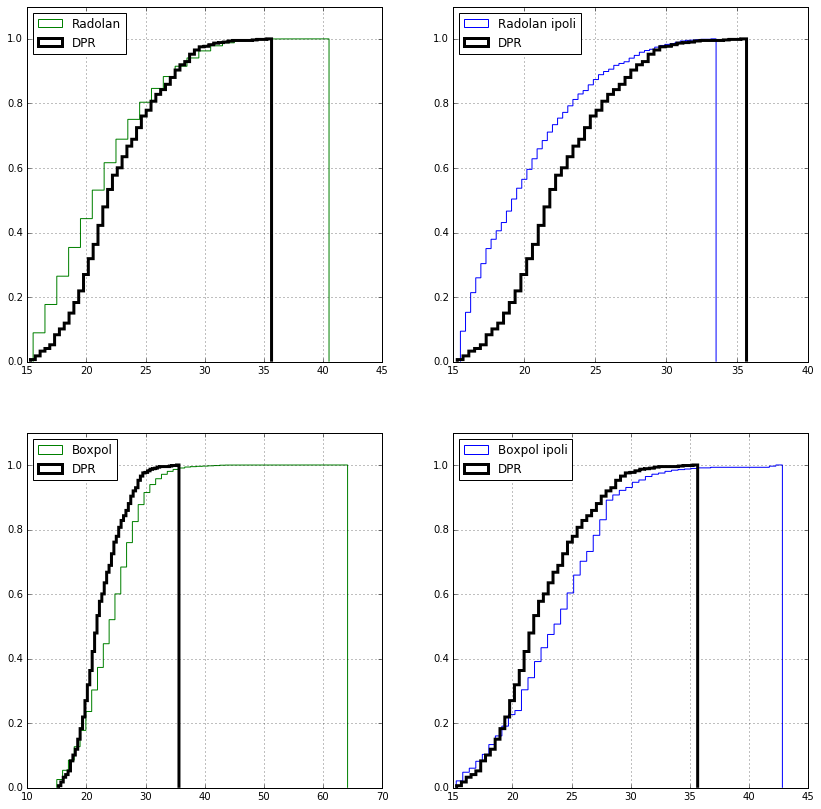

In [20]:
m4, m5 =  ~np.isnan(Z_boxpol),~np.isnan(Z_radolan)
ll = 1
fig = plt.figure(figsize=(14,14))

plt.subplot(2,2,1)
plt.hist(Z_radolan[m5], bins=bb, alpha=aa, label='Radolan',facecolor="None",
         edgecolor='green', linewidth=ll, normed=1,cumulative=True, histtype='step')
plt.hist(Z_dpr[m1], bins=bb, alpha=aa, label='DPR',facecolor="None",
         edgecolor='black', linewidth=3, normed=1,cumulative=True, histtype='step')
plt.ylim(0,1.1)
plt.grid()
plt.legend(loc='upper left')
plt.subplot(2,2,3)
plt.hist(Z_boxpol[m4], bins=bb, alpha=aa, label='Boxpol',facecolor="None",
         edgecolor='green', linewidth=ll, normed=1,cumulative=True, histtype='step')
plt.hist(Z_dpr[m1], bins=bb, alpha=aa, label='DPR',facecolor="None",
         edgecolor='black', linewidth=3, normed=1,cumulative=True, histtype='step')
plt.ylim(0,1.1)
plt.grid()
plt.legend(loc='upper left')

plt.subplot(2,2,2)
plt.hist(Z_radolan_ipoli[m3], bins=bb, alpha=aa, label='Radolan ipoli',facecolor="None",
         edgecolor='blue', linewidth=ll, normed=1,cumulative=True, histtype='step')
plt.hist(Z_dpr[m1], bins=bb, alpha=aa, label='DPR',facecolor="None",
         edgecolor='black', linewidth=3, normed=1,cumulative=True, histtype='step')
plt.ylim(0,1.1)
plt.grid()
plt.legend(loc='upper left')
plt.subplot(2,2,4)
plt.hist(Z_boxpol_ipoli[m2], bins=bb, alpha=aa, label='Boxpol ipoli',facecolor="None",
        edgecolor='blue', linewidth=ll, normed=1,cumulative=True, histtype='step')
plt.hist(Z_dpr[m1], bins=bb, alpha=aa, label='DPR',facecolor="None",
         edgecolor='black', linewidth=3, normed=1,cumulative=True, histtype='step')
plt.ylim(0,1.1)
plt.grid()
plt.legend(loc='upper left')
plt.savefig('/automount/ags/velibor/plot/GPM_boxpol/topevents/cxkb_'+ZP+'.png')
plt.show()

In [21]:
np.save('/automount/ags/velibor/data/dpr_boxpol/'+ZP+'.npy',[Z_dpr,Z_boxpol,Z_boxpol_ipoli,Z_radolan,Z_radolan_ipoli])

# Statistics..................
----------------------------------


In [5]:
import os
all_dpr, all_box, all_rad = np.array([]),np.array([]),np.array([])

path = '/automount/ags/velibor/data/dpr_boxpol/'
c_liste = sorted(glob.glob(path+'/*.npy'))
for iii in range(len(c_liste)-1):
    
    a = np.load(c_liste[iii])[0]
    b = np.load(c_liste[iii])[2]
    c = np.load(c_liste[iii])[4]
    
    a = a.reshape(a.shape[0]*a.shape[1])
    b = b.reshape(b.shape[0]*b.shape[1])
    c = c.reshape(c.shape[0]*c.shape[1])
    
    print a.shape,b.shape,c.shape
    
    all_dpr = np.append(all_dpr,a)
    all_box = np.append(all_box,b)
    all_rad = np.append(all_rad,c)
    

    
print all_dpr.shape, all_box.shape, all_rad.shape


(16219,) (16219,) (16219,)
(10927,) (10927,) (10927,)
(10927,) (10927,) (10927,)
(15680,) (15680,) (15680,)
(11074,) (11074,) (11074,)
(15876,) (15876,) (15876,)
(13377,) (13377,) (13377,)
(13083,) (13083,) (13083,)
(16023,) (16023,) (16023,)
(15239,) (15239,) (15239,)
(15239,) (15239,) (15239,)
(15337,) (15337,) (15337,)
(14798,) (14798,) (14798,)
(14406,) (14406,) (14406,)
(16268,) (16268,) (16268,)
(15141,) (15141,) (15141,)
(12348,) (12348,) (12348,)
(241962,) (241962,) (241962,)


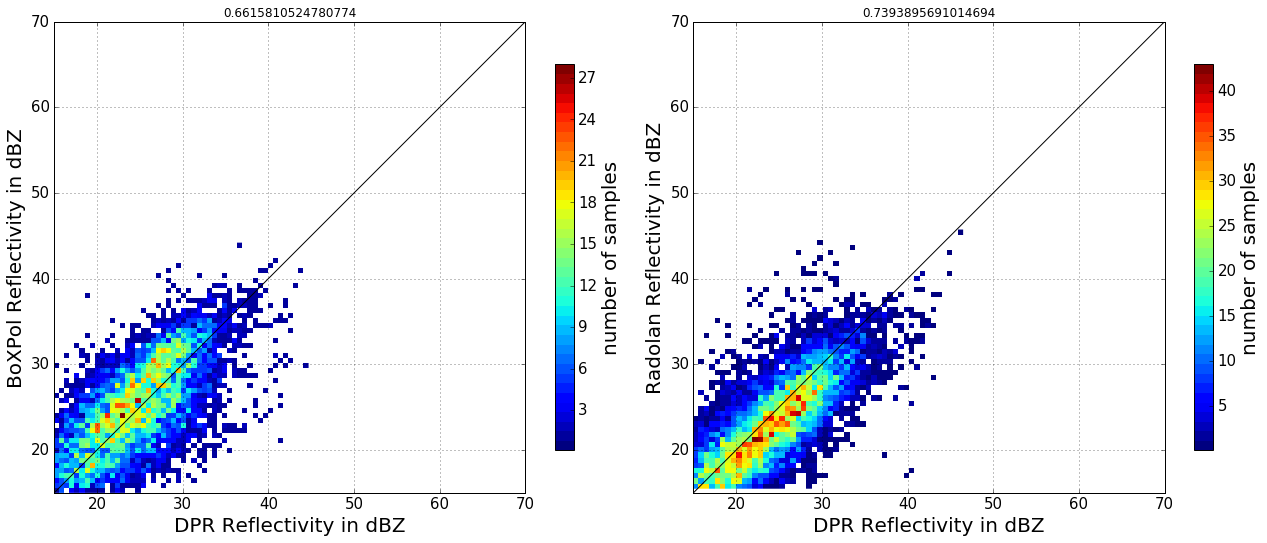

In [6]:
from pcc import get_my_cmap2
m1 = ~np.isnan(all_dpr) & ~np.isnan(all_box) 
m2 = ~np.isnan(all_dpr) & ~np.isnan(all_rad) 

ff, ff2 = 15,20
bb=50
fig =plt.figure(figsize=(18,8))
ax2 = fig.add_subplot(121, aspect='equal')
plt.hist2d(all_dpr[m1],all_box[m1], bins=bb, cmap=get_my_cmap2(),vmin=0.1)

cbar = plt.colorbar(shrink=0.7)
cbar.set_label('number of samples', fontsize=ff2)
cbar.ax.tick_params(labelsize=ff)

#plt.title('Liquid Phase Corr: ' + str(round(z_corr,3)) + r'$\pm$'+  str(round(z_eror,3)), fontsize=ff2)
plt.xlim(15,70)
plt.ylim(15,70)
cx,cy = np.arange(0,80,1),np.arange(0,80,1)
plt.plot(cx,cy, color='black')
plt.xlabel('DPR Reflectivity in dBZ',fontsize=ff2)
plt.ylabel('BoXPol Reflectivity in dBZ',fontsize=ff2)
plt.title(corcor(all_dpr,all_box))

plt.grid()
plt.xticks(fontsize=ff)
plt.yticks(fontsize=ff)


x3 = fig.add_subplot(122, aspect='equal')
plt.hist2d(all_dpr[m2],all_rad[m2], bins=bb, cmap=get_my_cmap2(),vmin=0.1)

cbar = plt.colorbar(shrink=0.7)
cbar.set_label('number of samples', fontsize=ff2)
cbar.ax.tick_params(labelsize=ff)

#plt.title('Liquid Phase Corr: ' + str(round(z_corr,3)) + r'$\pm$'+  str(round(z_eror,3)), fontsize=ff2)
plt.xlim(15,70)
plt.ylim(15,70)
cx,cy = np.arange(0,80,1),np.arange(0,80,1)
plt.plot(cx,cy, color='black')
plt.xlabel('DPR Reflectivity in dBZ',fontsize=ff2)
plt.ylabel('Radolan Reflectivity in dBZ',fontsize=ff2)
plt.title(corcor(all_dpr,all_rad))

plt.grid()
plt.xticks(fontsize=ff)
plt.yticks(fontsize=ff)
#plt.savefig('/automount/ags/velibor/plot/IRS/NSliquidWS_Ref.png')
#plt.close()
plt.tight_layout()
plt.show()

In [4]:
md = ~np.isnan(all_dpr)
mb = ~np.isnan(all_box)
mr = ~np.isnan(all_rad)


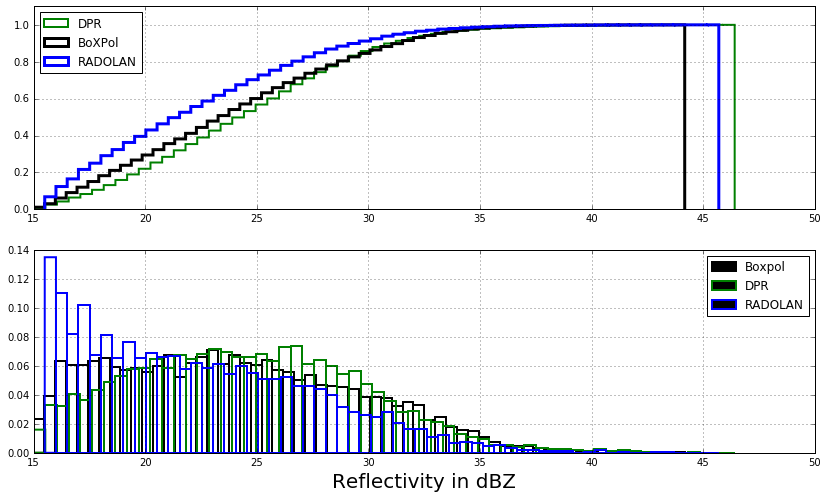

In [27]:
bb, aa, ll = 60, 1, 2
fig = plt.figure(figsize=(14,8))
plt.subplot(2,1,1)

plt.hist(all_dpr[md], bins=bb, alpha=aa, label='DPR',facecolor="None",
         edgecolor='green', linewidth=ll, normed=1,cumulative=True, histtype='step')
plt.hist(all_box[mb], bins=bb, alpha=aa, label='BoXPol',facecolor="None",
         edgecolor='black', linewidth=3, normed=1,cumulative=True, histtype='step')
plt.hist(all_rad[mr], bins=bb, alpha=aa, label='RADOLAN',facecolor="None",
         edgecolor='blue', linewidth=3, normed=1,cumulative=True, histtype='step')
plt.legend(loc='upper left')
plt.grid()
plt.ylim(0,1.1)

plt.subplot(2,1,2)
plt.hist(all_box[mb], bins=bb, alpha=aa, label='Boxpol',facecolor="None",
        edgecolor='black', linewidth=ll, normed=1)
plt.hist(all_dpr[md], bins=bb, alpha=aa, label='DPR',facecolor="None",
         edgecolor='green', linewidth=ll, normed=1)
plt.hist(all_rad[mr], bins=bb, alpha=aa, label='RADOLAN',facecolor="None",
         edgecolor='blue', linewidth=ll, normed=1)
plt.legend()
plt.xlabel('Reflectivity in dBZ',fontsize=ff2)

plt.grid()